Loading data...
Obs: 12393, Firms: 1223, Years: 2003–2022

Spec 1: collapse + diff-only
Estimating: invest_cap_sum DisagreementInvFCompDir Tobins_Q L1.invest_cap_sum L1.DisagreementInvFCompDir L1.Tobins_Q crisis_dummy covid_dummy | gmm(invest_cap_sum,3:5) iv(crisis_dummy covid_dummy) | collapse nolevel
 Dynamic panel-data estimation, two-step difference GMM
 Group variable: gvkey                           Number of obs = 8829    
 Time variable: fyear                            Min obs per group: 0    
 Number of instruments = 9                       Max obs per group: 17   
 Number of groups = 1223                         Avg obs per group: 7.22 
+----------------------------+------------+---------------------+-------------+-----------+-----+
|       invest_cap_sum       |   coef.    | Corrected Std. Err. |      z      |   P>|z|   |     |
+----------------------------+------------+---------------------+-------------+-----------+-----+
|     L1.invest_cap_sum      | 0.5069453  |      0

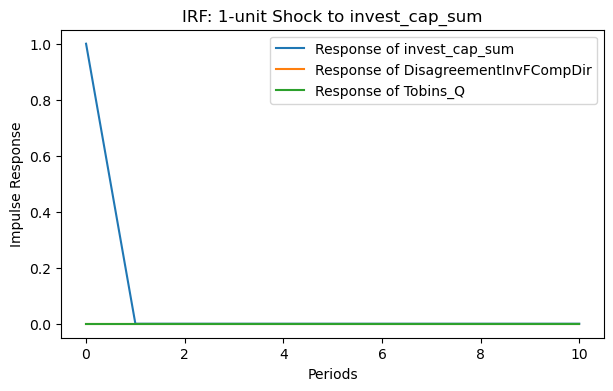

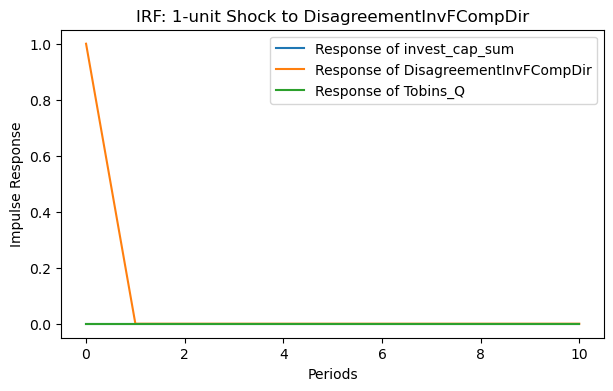

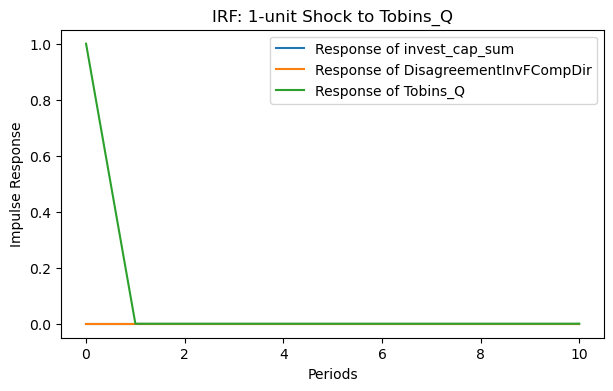


--- One-Step vs Two-Step System GMM Comparison ---
Estimating: invest_cap_sum DisagreementInvFCompDir Tobins_Q L1.invest_cap_sum L1.DisagreementInvFCompDir L1.Tobins_Q crisis_dummy covid_dummy | gmm(invest_cap_sum,3:5) iv(crisis_dummy covid_dummy) | collapse
 Dynamic panel-data estimation, two-step system GMM
 Group variable: gvkey                            Number of obs = 8829    
 Time variable: fyear                             Min obs per group: 0    
 Number of instruments = 11                       Max obs per group: 17   
 Number of groups = 1223                          Avg obs per group: 7.22 
+----------------------------+------------+---------------------+-------------+-----------+-----+
|       invest_cap_sum       |   coef.    | Corrected Std. Err. |      z      |   P>|z|   |     |
+----------------------------+------------+---------------------+-------------+-----------+-----+
|     L1.invest_cap_sum      | 0.6070801  |      0.0257460      |  23.5795990 | 0.0000000 | **

In [64]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pydynpd import regression
from sklearn.decomposition import PCA
import re

# ── Constants ──────────────────────────────────────────────────────────
BASE_VARS      = ["invest_cap_sum", "DisagreementInvFCompDir", "Tobins_Q"]
extended_vars  = ["cash_flow", "equity_issuance", "sales_growth", "ROA", "debt_to_asset"]
CONTROL_VARS   = ["crisis_dummy", "covid_dummy"]
GMM_LAGS = "3:5"
INDUSTRY_MAPPING = {
    range(1, 10): "Agriculture, Forestry, And Fishing",
    range(10, 14): "Mining",
    range(15, 17): "Construction",
    range(20, 39): "Manufacturing",
    range(40, 49): "Transportation & Utilities",
    (50, 51):     "Wholesale Trade",
    range(52, 59): "Retail Trade",
    range(60, 67): "Finance, Insurance & Real Estate",
    range(70, 89): "Services",
    range(91, 98): "Public Administration",
    (99,):         "Nonclassifiable Establishments"
}

def extract_lag1_coefs_from_abond(model, vars_=BASE_VARS):
    summary = str(model)
    pattern = re.compile(r"L1\.([A-Za-z0-9_]+)\s*\|\s*([-\.0-9eE]+)")
    matches = pattern.findall(summary)
    lag1_dict = {k: float(v) for k, v in matches}
    return lag1_dict

class DynamicPanelAnalysis:
    def __init__(self, df, sic_level=2):
        self.df = df.copy()
        self.sic_level = sic_level
        self.analysis_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.prepare_data()

    def get_industry_name(self, sic2):
        for key, val in INDUSTRY_MAPPING.items():
            if isinstance(key, range) and sic2 in key:
                return val
            if isinstance(key, tuple) and sic2 in key:
                return val
        return "Other"

    def prepare_data(self):
        if self.sic_level == 2:
            self.df["sic2"] = self.df["sic"].astype(str).str[:2].astype(int)
            self.df["industry_name"] = self.df["sic2"].apply(self.get_industry_name)
        self.df.sort_values(["gvkey", "fyear"], inplace=True)
        self.df["trend"] = self.df["fyear"] - self.df["fyear"].min() + 1
        self.df["trend_sq"] = self.df["trend"] ** 2
        self.df["crisis_dummy"] = self.df["fyear"].between(2007, 2009).astype(int)
        self.df["covid_dummy"] = self.df["fyear"].between(2020, 2021).astype(int)
        self.ensure_lags(BASE_VARS, L=2)
        self._compute_pca_instruments()
        self._winsorise()

    def _winsorise(self, lim=(0.01, 0.99)):
        for v in BASE_VARS + extended_vars + ["PC1", "PC2"]:
            if v in self.df:
                lo, hi = self.df[v].quantile(lim[0]), self.df[v].quantile(lim[1])
                self.df[v] = self.df[v].clip(lo, hi)

    def ensure_lags(self, vars_, L=2):
        for v in vars_:
            for lag in range(1, L+1):
                self.df[f"lag_{lag}_{v}"] = self.df.groupby("gvkey")[v].shift(lag)

    def _compute_pca_instruments(self):
        lag_cols = [f"lag_{lag}_{v}" for v in BASE_VARS[:2] for lag in (1,2)]
        sub = self.df.dropna(subset=lag_cols)
        if sub.shape[0] == 0:
            return
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(sub[lag_cols])
        self.df.loc[sub.index, "PC1"] = pcs[:,0]
        self.df.loc[sub.index, "PC2"] = pcs[:,1]

    def stationarity_tests(self, data, vars_, min_obs=6):
        out = {}
        for v in vars_:
            panel = data.pivot(index="fyear", columns="gvkey", values=v).dropna(axis=1, thresh=min_obs)
            pvals = []
            for col in panel.columns:
                s = panel[col].dropna()
                if s.nunique() < 2: continue
                try:
                    pvals.append(adfuller(s, regression="c")[1])
                except:
                    continue
            res = {}
            if pvals:
                stat = -np.sqrt(len(pvals)) * (np.mean(pvals) - 0.5)
                res["IPS_p"] = 1 - stats.norm.cdf(stat)
            demeaned = panel.loc[:, panel.nunique()>1].sub(panel.mean(axis=1), axis=0)
            pooled = demeaned.values.flatten()
            pooled = pooled[~np.isnan(pooled)]
            if pooled.size > 10 and pooled.max() != pooled.min():
                res["LLC_p"] = adfuller(pooled, regression="c")[1]
            out[v] = res
        return out

    def build_command(self, vars_, collapse=True, diff_only=False, onestep=False, use_pca=False):
        regressors = vars_ + [f"L1.{v}" for v in vars_] + CONTROL_VARS
        dep_reg = " ".join(regressors)
        if use_pca:
            iv_inst = f"iv({' '.join(CONTROL_VARS + ['PC1','PC2'])})"
            gmm_inst = ""
        else:
            iv_inst = f"iv({' '.join(CONTROL_VARS)})"
            gmm_inst = f"gmm(invest_cap_sum,{GMM_LAGS})"
        cmd = f"{dep_reg} | {gmm_inst} {iv_inst}".strip()
        opts = []
        if collapse: opts.append("collapse")
        if diff_only: opts.append("nolevel")
        if onestep: opts.append("onestep")
        if opts:
            cmd += " | " + " ".join(opts)
        return cmd

    def run_pvar_model(self, data, vars_, collapse=False, diff_only=False, onestep=False, use_pca=False):
        data = data.copy()
        st = self.stationarity_tests(data, vars_)
        diff_vars = [v for v,r in st.items() if r.get('IPS_p',1)>0.05 and r.get('LLC_p',1)>0.05]
        if diff_vars:
            for v in diff_vars:
                data[v] = data.groupby('gvkey')[v].diff()
            data.dropna(subset=diff_vars, inplace=True)
            self.ensure_lags(diff_vars, 2)
        self.ensure_lags(vars_, L=2)

        cmd = self.build_command(vars_, collapse, diff_only, onestep, use_pca)
        print("Estimating:", cmd)
        model = regression.abond(cmd, data, ["gvkey","fyear"])
        summary = str(model)

        # parse diagnostics
        m0 = re.search(r"Number of instruments =\s*(\d+)", summary)
        ninst = int(m0.group(1)) if m0 else None
        m1 = re.search(r"Prob > Chi2 =\s*([0-9\.]+)", summary)
        hansen = float(m1.group(1)) if m1 else None
        m2 = re.search(r"AR\(2\).*Pr > z =\s*([0-9\.]+)", summary)
        ar2 = float(m2.group(1)) if m2 else None

        ninst_str = ninst if ninst is not None else 'NA'
        hansen_str = f"{hansen:.3g}" if hansen is not None else 'NA'
        ar2_str = f"{ar2:.3g}" if ar2 is not None else 'NA'
        print(f" → Instruments = {ninst_str}, Hansen p = {hansen_str}, AR(2) p = {ar2_str}")

        return {"model": model, "hansen": hansen, "ar2": ar2, "ninst": ninst}

    def run_industry_analysis(self, min_obs=200, **kwargs):
        results = {}
        for ind in self.df["industry_name"].unique():
            sub = self.df[self.df["industry_name"] == ind].copy()
            if len(sub) < min_obs or sub.gvkey.nunique() < 30: continue
            print(f"\nIndustry: {ind}")
            res = self.run_pvar_model(sub, BASE_VARS, **kwargs)
            if res['hansen'] and res['hansen'] > 0.05:
                print(" → Passed Hansen")
                results[ind] = res
            else:
                print(" → Failed Hansen")
        return results

    def run_mean_group(self, use_fe=True):
        import statsmodels.api as sm
        coefs = []
        for firm, sub in self.df.groupby('gvkey'):
            X = sub[BASE_VARS]
            if use_fe:
                X = sub[BASE_VARS].apply(lambda col: col - col.mean())
            y = sub['invest_cap_sum']
            res = sm.OLS(y, sm.add_constant(X)).fit()
            coefs.append(res.params[BASE_VARS])
        return pd.DataFrame(coefs).mean()

# ── Execute Analysis ──
print("Loading data...")
df = pd.read_csv("clean_panel.csv")
print(f"Obs: {len(df)}, Firms: {df.gvkey.nunique()}, Years: {df.fyear.min()}–{df.fyear.max()}")
analysis = DynamicPanelAnalysis(df)

def extract_lag1_matrix_from_abond(model, vars_=BASE_VARS):
    summary = str(model)
    pattern = re.compile(r"L1\.([A-Za-z0-9_]+)\s*\|\s*([-\.0-9eE]+)")
    matches = pattern.findall(summary)
    lag1_dict = {k: float(v) for k, v in matches}
    n = len(vars_)
    A = np.zeros((n, n))
    for i, v_row in enumerate(vars_):
        for j, v_col in enumerate(vars_):
            key = v_col
            try:
                A[i, j] = lag1_dict[key]
            except KeyError:
                A[i, j] = 0
    return A

def run_specs():
    print("\nSpec 1: collapse + diff-only")
    full1 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, diff_only=True)
    print("\nSpec 2: collapse + one-step")
    full2 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, onestep=True)
    print("\nSpec 3: PCA + collapse + diff-only")
    full3 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, diff_only=True, use_pca=True)
    print("\nIndustry-level (collapse + diff-only):")
    ind_res = analysis.run_industry_analysis(collapse=True, diff_only=True)
    print("\nMean-Group FE averages:")
    mg = analysis.run_mean_group()
    print(mg)

def get_var_matrix(model, vars_=BASE_VARS):
    n = len(vars_)
    A = np.zeros((n, n))
    for i, v_row in enumerate(vars_):
        for j, v_col in enumerate(vars_):
            coef_name = f"L1.{v_col}"
            try:
                A[i, j] = model.params[coef_name]
            except KeyError:
                A[i, j] = 0
    return A

def simulate_irf(A, shock_idx, n_steps=10):
    n_vars = A.shape[0]
    irfs = np.zeros((n_vars, n_steps + 1))
    irfs[shock_idx, 0] = 1
    for t in range(1, n_steps + 1):
        irfs[:, t] = A @ irfs[:, t - 1]
    return irfs

def compare_one_two_step(res_one, res_two, vars_=BASE_VARS):
    coefs_one = extract_lag1_coefs_from_abond(res_one["model"], vars_)
    coefs_two = extract_lag1_coefs_from_abond(res_two["model"], vars_)
    tab = pd.DataFrame({
        "Variable": [f"L1.{v}" for v in vars_],
        "One-Step": [coefs_one.get(v, float('nan')) for v in vars_],
        "Two-Step": [coefs_two.get(v, float('nan')) for v in vars_],
    })
    tab.loc[len(tab)] = ["Hansen p-value", res_one["hansen"], res_two["hansen"]]
    tab.loc[len(tab)] = ["AR(2) p-value", res_one["ar2"], res_two["ar2"]]
    return tab

if __name__ == "__main__":
    run_specs()

    print("\n--- IRF Simulation (Full Sample, One-Step) ---")
    full1 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, onestep=True)
    A = extract_lag1_matrix_from_abond(full1["model"], BASE_VARS)
    for i, var in enumerate(BASE_VARS):
        irfs = simulate_irf(A, i, n_steps=10)
        plt.figure(figsize=(7,4))
        for j, outvar in enumerate(BASE_VARS):
            plt.plot(range(11), irfs[j, :], label=f"Response of {outvar}")
        plt.title(f"IRF: 1-unit Shock to {var}")
        plt.xlabel("Periods")
        plt.ylabel("Impulse Response")
        plt.legend()
        plt.show()

    print("\n--- One-Step vs Two-Step System GMM Comparison ---")
    full2 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, onestep=False)
    comp_tab = compare_one_two_step(full1, full2)
    print(comp_tab)





Loading data...
Obs: 12393, Firms: 1223, Years: 2003–2022

Spec 1: collapse + diff-only, minimal GMM/IV
--- Panel diagnostic after differencing ---
       invest_cap_sum  DisagreementInvFCompDir      Tobins_Q
count    12393.000000             12393.000000  12393.000000
mean         0.078545                 0.123109      1.768296
std          0.041497                 0.126487      1.347826
min          0.003801                 0.001349      0.200000
25%          0.047545                 0.039928      0.594544
50%          0.073874                 0.078778      1.446772
75%          0.105385                 0.158657      2.733889
max          0.167017                 0.654271      4.866571
Data rows after differencing: 12393
Median firm years after diff: 10.0
Min firm years after diff: 1
Estimating: invest_cap_sum DisagreementInvFCompDir Tobins_Q L1.invest_cap_sum L1.DisagreementInvFCompDir L1.Tobins_Q | gmm(invest_cap_sum,5:5) iv() | collapse nolevel
iv(): invalid GMM or IV statement
GM

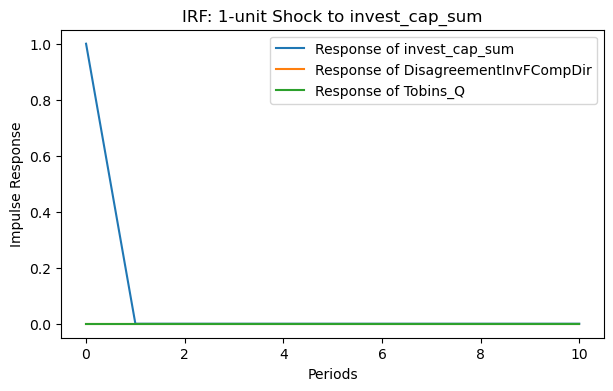

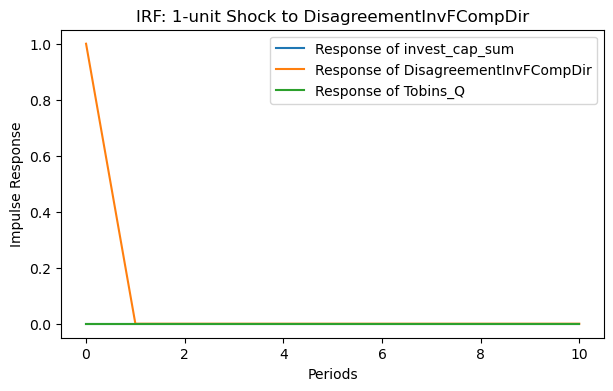

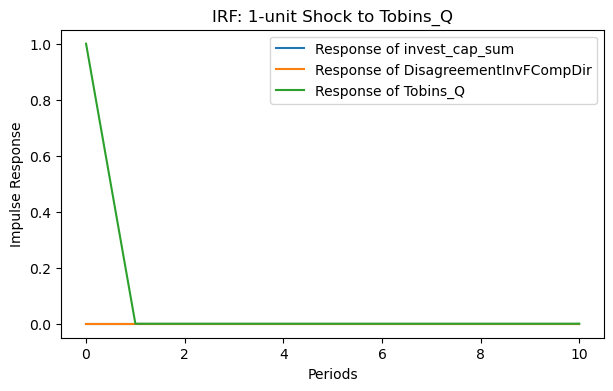


--- Collapse+DiffOnly vs Collapse+DiffOnly w/ Crisis Dummy Comparison ---
--- Panel diagnostic after differencing ---
       invest_cap_sum  DisagreementInvFCompDir      Tobins_Q
count    12393.000000             12393.000000  12393.000000
mean         0.078545                 0.123109      1.768296
std          0.041497                 0.126487      1.347826
min          0.003801                 0.001349      0.200000
25%          0.047545                 0.039928      0.594544
50%          0.073874                 0.078778      1.446772
75%          0.105385                 0.158657      2.733889
max          0.167017                 0.654271      4.866571
Data rows after differencing: 12393
Median firm years after diff: 10.0
Min firm years after diff: 1
Estimating: invest_cap_sum DisagreementInvFCompDir Tobins_Q L1.invest_cap_sum L1.DisagreementInvFCompDir L1.Tobins_Q crisis_dummy | gmm(invest_cap_sum,5:5) iv(crisis_dummy) | collapse nolevel
 Dynamic panel-data estimation, two-step

In [71]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pydynpd import regression
from sklearn.decomposition import PCA
import re

# ── Constants ──────────────────────────────────────────────────────────
BASE_VARS = ["invest_cap_sum", "DisagreementInvFCompDir", "Tobins_Q"]
extended_vars = ["cash_flow", "equity_issuance", "sales_growth", "ROA", "debt_to_asset"]
CONTROL_VARS = []  # Only add dummies if theory/diagnostics demand
GMM_LAGS = "5:5"  # Minimal: Only 1 high-order lag
INDUSTRY_MAPPING = {
    range(1, 10): "Agriculture, Forestry, And Fishing",
    range(10, 14): "Mining",
    range(15, 17): "Construction",
    range(20, 39): "Manufacturing",
    range(40, 49): "Transportation & Utilities",
    (50, 51):     "Wholesale Trade",
    range(52, 59): "Retail Trade",
    range(60, 67): "Finance, Insurance & Real Estate",
    range(70, 89): "Services",
    range(91, 98): "Public Administration",
    (99,):         "Nonclassifiable Establishments"
}

def extract_lag1_coefs_from_abond(model, vars_=BASE_VARS):
    summary = str(model)
    pattern = re.compile(r"L1\.([A-Za-z0-9_]+)\s*\|\s*([-\.0-9eE]+)")
    matches = pattern.findall(summary)
    lag1_dict = {k: float(v) for k, v in matches}
    return lag1_dict

class DynamicPanelAnalysis:
    def __init__(self, df, sic_level=2):
        self.df = df.copy()
        self.sic_level = sic_level
        self.analysis_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.prepare_data()

    def get_industry_name(self, sic2):
        for key, val in INDUSTRY_MAPPING.items():
            if isinstance(key, range) and sic2 in key:
                return val
            if isinstance(key, tuple) and sic2 in key:
                return val
        return "Other"

    def prepare_data(self):
        if self.sic_level == 2:
            self.df["sic2"] = self.df["sic"].astype(str).str[:2].astype(int)
            self.df["industry_name"] = self.df["sic2"].apply(self.get_industry_name)
        self.df.sort_values(["gvkey", "fyear"], inplace=True)
        self.df["trend"] = self.df["fyear"] - self.df["fyear"].min() + 1
        self.df["trend_sq"] = self.df["trend"] ** 2
        self.df["crisis_dummy"] = self.df["fyear"].between(2007, 2009).astype(int)
        self.df["covid_dummy"] = self.df["fyear"].between(2020, 2021).astype(int)
        self.ensure_lags(BASE_VARS, L=2)
        self._compute_pca_instruments()
        self._winsorise()

    def _winsorise(self, lim=(0.01, 0.99)):
        for v in BASE_VARS + extended_vars + ["PC1", "PC2"]:
            if v in self.df:
                lo, hi = self.df[v].quantile(lim[0]), self.df[v].quantile(lim[1])
                self.df[v] = self.df[v].clip(lo, hi)

    def ensure_lags(self, vars_, L=2):
        for v in vars_:
            for lag in range(1, L+1):
                self.df[f"lag_{lag}_{v}"] = self.df.groupby("gvkey")[v].shift(lag)

    def _compute_pca_instruments(self):
        lag_cols = [f"lag_{lag}_{v}" for v in BASE_VARS[:2] for lag in (1,2)]
        sub = self.df.dropna(subset=lag_cols)
        if sub.shape[0] == 0:
            return
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(sub[lag_cols])
        self.df.loc[sub.index, "PC1"] = pcs[:,0]
        self.df.loc[sub.index, "PC2"] = pcs[:,1]

    def stationarity_tests(self, data, vars_, min_obs=6):
        out = {}
        for v in vars_:
            panel = data.pivot(index="fyear", columns="gvkey", values=v).dropna(axis=1, thresh=min_obs)
            pvals = []
            for col in panel.columns:
                s = panel[col].dropna()
                if s.nunique() < 2: continue
                try:
                    pvals.append(adfuller(s, regression="c")[1])
                except:
                    continue
            res = {}
            if pvals:
                stat = -np.sqrt(len(pvals)) * (np.mean(pvals) - 0.5)
                res["IPS_p"] = 1 - stats.norm.cdf(stat)
            demeaned = panel.loc[:, panel.nunique()>1].sub(panel.mean(axis=1), axis=0)
            pooled = demeaned.values.flatten()
            pooled = pooled[~np.isnan(pooled)]
            if pooled.size > 10 and pooled.max() != pooled.min():
                res["LLC_p"] = adfuller(pooled, regression="c")[1]
            out[v] = res
        return out

    def build_command(self, vars_, collapse=True, diff_only=True, onestep=False, use_pca=False, use_crisis=False):
        # Build minimal instrument set: Only GMM dependent, single lag (e.g. 5), collapse, nolevel, no IVs by default
        regressors = vars_ + [f"L1.{v}" for v in vars_]  # No controls by default
        dep_reg = " ".join(regressors)
        iv_inst = "iv()"
        gmm_inst = f"gmm(invest_cap_sum,{GMM_LAGS})"
        # Optionally add crisis_dummy as regressor/IV if needed
        if use_crisis:
            dep_reg += " crisis_dummy"
            iv_inst = "iv(crisis_dummy)"
        cmd = f"{dep_reg} | {gmm_inst} {iv_inst}".strip()
        opts = []
        if collapse: opts.append("collapse")
        if diff_only: opts.append("nolevel")
        if onestep: opts.append("onestep")
        if opts:
            cmd += " | " + " ".join(opts)
        return cmd

    def run_pvar_model(self, data, vars_, collapse=True, diff_only=True, onestep=False, use_pca=False, use_crisis=False):
        data = data.copy()
        st = self.stationarity_tests(data, vars_)
        diff_vars = [v for v, r in st.items() if r.get('IPS_p', 1) > 0.05 and r.get('LLC_p', 1) > 0.05]
        if diff_vars:
            for v in diff_vars:
                data[v] = data.groupby('gvkey')[v].diff()
            data.dropna(subset=diff_vars, inplace=True)
            self.ensure_lags(diff_vars, 2)
        self.ensure_lags(vars_, L=2)

        # <<< ADD PANEL DIAGNOSTICS HERE >>>
        print('--- Panel diagnostic after differencing ---')
        print(data[BASE_VARS].describe())
        print(f"Data rows after differencing: {len(data)}")
        panel_sizes = data.groupby('gvkey').size()
        print("Median firm years after diff:", panel_sizes.median())
        print("Min firm years after diff:", panel_sizes.min())

        cmd = self.build_command(vars_, collapse, diff_only, onestep, use_pca, use_crisis)
        print("Estimating:", cmd)
        try:
            model = regression.abond(cmd, data, ["gvkey", "fyear"])
        except SystemExit:
            print("GMM estimation failed: insufficient or incompatible data after differencing/stationarity checks.")
            return {"model": None, "hansen": None, "ar2": None, "ninst": None}

        summary = str(model)   # assign summary here
        print(model)           # Print the whole model for debugging


        # parse diagnostics
        m0 = re.search(r"Number of instruments =\s*(\d+)", summary)
        ninst = int(m0.group(1)) if m0 else None
        m1 = re.search(r"Prob > Chi2 =\s*([0-9\.]+)", summary)
        hansen = float(m1.group(1)) if m1 else None
        m2 = re.search(r"AR\(2\).*Pr > z =\s*([0-9\.]+)", summary)
        ar2 = float(m2.group(1)) if m2 else None

        ninst_str = ninst if ninst is not None else 'NA'
        hansen_str = f"{hansen:.3g}" if hansen is not None else 'NA'
        ar2_str = f"{ar2:.3g}" if ar2 is not None else 'NA'
        print(f" → Instruments = {ninst_str}, Hansen p = {hansen_str}, AR(2) p = {ar2_str}")

        return {"model": model, "hansen": hansen, "ar2": ar2, "ninst": ninst}

    def run_industry_analysis(self, min_obs=250, **kwargs):
        results = {}
        for ind in self.df["industry_name"].unique():
            sub = self.df[self.df["industry_name"] == ind].copy()
            # Only keep big-enough panels
            valid_firms = sub.groupby('gvkey').filter(lambda x: len(x) >= 7)
            if len(valid_firms) < min_obs or valid_firms.gvkey.nunique() < 30:
                print(f"Skipping {ind}: not enough obs/firms.")
                continue
            print(f"\nIndustry: {ind}")
            res = self.run_pvar_model(valid_firms, BASE_VARS, **kwargs)
            if res['hansen'] and res['hansen'] > 0.05:
                print(" → Passed Hansen")
                results[ind] = res
            else:
                print(" → Failed Hansen")
        return results

    def run_mean_group(self, use_fe=True):
        import statsmodels.api as sm
        coefs = []
        for firm, sub in self.df.groupby('gvkey'):
            X = sub[BASE_VARS]
            if use_fe:
                X = sub[BASE_VARS].apply(lambda col: col - col.mean())
            y = sub['invest_cap_sum']
            res = sm.OLS(y, sm.add_constant(X)).fit()
            coefs.append(res.params[BASE_VARS])
        return pd.DataFrame(coefs).mean()

# ── Execute Analysis ──
print("Loading data...")
df = pd.read_csv("clean_panel.csv")
print(f"Obs: {len(df)}, Firms: {df.gvkey.nunique()}, Years: {df.fyear.min()}–{df.fyear.max()}")
analysis = DynamicPanelAnalysis(df)

def run_specs():
    print("\nSpec 1: collapse + diff-only, minimal GMM/IV")
    full1 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, diff_only=True)
    print("\nSpec 2: collapse + diff-only, with crisis_dummy as IV if needed")
    full2 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, diff_only=True, use_crisis=True)
    print("\nIndustry-level (collapse + diff-only, minimal)")
    ind_res = analysis.run_industry_analysis(collapse=True, diff_only=True)
    print("\nMean-Group FE averages:")
    mg = analysis.run_mean_group()
    print(mg)

def extract_lag1_matrix_from_abond(model, vars_=BASE_VARS):
    summary = str(model)
    pattern = re.compile(r"L1\.([A-Za-z0-9_]+)\s*\|\s*([-\.0-9eE]+)")
    matches = pattern.findall(summary)
    lag1_dict = {k: float(v) for k, v in matches}
    n = len(vars_)
    A = np.zeros((n, n))
    for i, v_row in enumerate(vars_):
        for j, v_col in enumerate(vars_):
            key = v_col
            try:
                A[i, j] = lag1_dict[key]
            except KeyError:
                A[i, j] = 0
    return A

def simulate_irf(A, shock_idx, n_steps=10):
    n_vars = A.shape[0]
    irfs = np.zeros((n_vars, n_steps + 1))
    irfs[shock_idx, 0] = 1
    for t in range(1, n_steps + 1):
        irfs[:, t] = A @ irfs[:, t - 1]
    return irfs

def compare_one_two_step(res_one, res_two, vars_=BASE_VARS):
    coefs_one = extract_lag1_coefs_from_abond(res_one["model"], vars_)
    coefs_two = extract_lag1_coefs_from_abond(res_two["model"], vars_)
    tab = pd.DataFrame({
        "Variable": [f"L1.{v}" for v in vars_],
        "CollapseDiffOnly": [coefs_one.get(v, float('nan')) for v in vars_],
        "CollapseDiffOnlyCrisis": [coefs_two.get(v, float('nan')) for v in vars_],
    })
    tab.loc[len(tab)] = ["Hansen p-value", res_one["hansen"], res_two["hansen"]]
    tab.loc[len(tab)] = ["AR(2) p-value", res_one["ar2"], res_two["ar2"]]
    return tab

if __name__ == "__main__":
    run_specs()

    print("\n--- IRF Simulation (Full Sample, Collapse+DiffOnly) ---")
    full1 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, diff_only=True)
    A = extract_lag1_matrix_from_abond(full1["model"], BASE_VARS)
    for i, var in enumerate(BASE_VARS):
        irfs = simulate_irf(A, i, n_steps=10)
        plt.figure(figsize=(7,4))
        for j, outvar in enumerate(BASE_VARS):
            plt.plot(range(11), irfs[j, :], label=f"Response of {outvar}")
        plt.title(f"IRF: 1-unit Shock to {var}")
        plt.xlabel("Periods")
        plt.ylabel("Impulse Response")
        plt.legend()
        plt.show()

    print("\n--- Collapse+DiffOnly vs Collapse+DiffOnly w/ Crisis Dummy Comparison ---")
    full2 = analysis.run_pvar_model(analysis.df, BASE_VARS, collapse=True, diff_only=True, use_crisis=True)
    comp_tab = compare_one_two_step(full1, full2)
    print(comp_tab)
